## Libraries

In [2]:
import json
import pickle
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.animation as animation
import matplotlib.colors as mcolors

## TEST

In [3]:
# -------------------------------
# Hàm chuyển đổi dữ liệu từ file JSON
# -------------------------------
def parse_order(order_data):
    canvas_size = order_data.get("canvas_size", [100, 100])
    mapping = {"table": 1, "chair": 2, "leg": 3}
    products = []
    for item_name, details in order_data["items"].items():
        prod = {
            "id": mapping.get(item_name, len(products) + 1),
            "name": item_name.capitalize(),
            "width": details["size"][0],
            "length": details["size"][1],
            "quantity": details["quantity"]
        }
        products.append(prod)
    return canvas_size, products

In [4]:
# -------------------------------
# Hàm kiểm tra sát cạnh
# -------------------------------
def is_adjacent(pos1, size1, pos2, size2):
    r1, c1 = pos1
    w1, h1 = size1
    r2, c2 = pos2
    w2, h2 = size2
    top1, bottom1, left1, right1 = r1, r1 + h1, c1, c1 + w1
    top2, bottom2, left2, right2 = r2, r2 + h2, c2, c2 + w2
    horizontal_adj = ((bottom1 > top2) and (top1 < bottom2)) and (abs(right1 - left2) == 0 or abs(right2 - left1) == 0)
    vertical_adj   = ((right1 > left2) and (left1 < right2)) and (abs(bottom1 - top2) == 0 or abs(bottom2 - top1) == 0)
    return horizontal_adj or vertical_adj


In [5]:
# -------------------------------
# Lớp môi trường cắt tấm
# -------------------------------
class MultiStockCuttingEnv:
    def __init__(self, canvas_size, products_data):
        self.canvas_size = canvas_size  # Ví dụ: [100, 100]
        self.products_data = products_data
        self.reset()
        
    def reset(self):
        w, h = self.canvas_size
        self.stocks = [self.create_new_stock(1)]
        self.products = [dict(p) for p in self.products_data]
        self.placements = []
        return self.get_state()
    
    def create_new_stock(self, stock_id):
        w, h = self.canvas_size
        return {
            "id": stock_id,
            "width": w,
            "length": h,
            "grid": np.full((h, w), -1)
        }
    
    def get_active_stock(self):
        return self.stocks[-1]
    
    def get_state(self):
        active = self.get_active_stock()
        flat_grid = active["grid"].flatten().tolist()
        quantities = [p["quantity"] for p in self.products]
        return tuple(flat_grid + quantities)
    
    def is_done(self):
        return not any(p["quantity"] > 0 for p in self.products)
    
    def get_possible_actions(self):
        return [p["id"] for p in self.products if p["quantity"] > 0]
    
    def step(self, action):
        product = next((p for p in self.products if p["id"] == action), None)
        if not product:
            return self.get_state(), -1
        
        w, h = product["width"], product["length"]
        active = self.get_active_stock()
        placed, pos = self.try_place_on_stock(active, action, w, h)
        if not placed:
            new_id = self.stocks[-1]["id"] + 1
            new_stock = self.create_new_stock(new_id)
            self.stocks.append(new_stock)
            placed, pos = self.try_place_on_stock(new_stock, action, w, h)
            if not placed:
                return self.get_state(), -1
        
        product["quantity"] -= 1
        self.placements.append({
            "stock_id": self.get_active_stock()["id"],
            "piece_id": action,
            "pos": pos,
            "size": (w, h)
        })
        reward = self.compute_reward(action, pos, (w, h))
        return self.get_state(), reward

    def try_place_on_stock(self, stock, action, w, h):
        grid = stock["grid"]
        b_w, b_h = stock["width"], stock["length"]
        for r in range(b_h - h + 1):
            for c in range(b_w - w + 1):
                if np.all(grid[r:r+h, c:c+w] == -1):
                    if not (r == 0 or c == 0 or (r+h == b_h) or (c+w == b_w)):
                        continue
                    grid[r:r+h, c:c+w] = action
                    return True, (r, c)
        return False, None

    def compute_reward(self, piece_id, pos, size):
        if piece_id == 1:
            tables = [p for p in self.placements if p["piece_id"] == 1]
            if len(tables) == 0:
                active = self.get_active_stock()
                corners = [
                    (0, 0),
                    (0, active["width"] - size[0]),
                    (active["length"] - size[1], 0),
                    (active["length"] - size[1], active["width"] - size[0])
                ]
                return 10 if pos in corners else 1
            elif len(tables) == 1:
                first = tables[0]
                sat = is_adjacent(pos, size, first["pos"], first["size"])
                active = self.get_active_stock()
                touches = (pos[0] == 0 or pos[1] == 0 or (pos[0] + size[1] == active["length"]) or (pos[1] + size[0] == active["width"]))
                return 8 if sat and touches else 1
            else:
                return self.reward_for_other(pos, size)
        else:
            return self.reward_for_other(pos, size)
    
    def reward_for_other(self, pos, size):
        active = self.get_active_stock()
        if pos[0] == 0 or pos[1] == 0 or (pos[0] + size[1] == active["length"]) or (pos[1] + size[0] == active["width"]):
            return 5
        for p in self.placements:
            if p["pos"] == pos and p["size"] == size:
                continue
            if is_adjacent(pos, size, p["pos"], p["size"]):
                return 5
        return 1
    
    def leftover_penalty(self):
        total_leftover = 0
        for s in self.stocks:
            total_leftover += np.sum(s["grid"] == -1)
        return -0.01 * total_leftover
    
    def complete_bonus(self):
        return 50 if all(p["quantity"] == 0 for p in self.products) else 0
    
    def stock_switch_penalty(self):
        extra_stocks = len(self.stocks) - 1
        return -50 * extra_stocks


In [6]:
# -------------------------------
# Q-LEARNING AGENT
# -------------------------------
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon  # Nếu có pretrain, khi mô phỏng bạn có thể đặt epsilon = 0
        self.q_table = {}
    
    def get_state_key(self, state):
        return tuple(state)
    
    def choose_action(self, state, possible_actions):
        key = self.get_state_key(state)
        if random.random() < self.epsilon:
            return random.choice(possible_actions)
        q_vals = [self.q_table.get((key, a), 0) for a in possible_actions]
        max_q = max(q_vals) if q_vals else 0
        best_actions = [a for a, q in zip(possible_actions, q_vals) if q == max_q]
        return random.choice(best_actions) if best_actions else random.choice(possible_actions)


In [ ]:
# -------------------------------
# HUẤN LUYỆN Q-LEARNING (Nếu cần)
# -------------------------------
def train_q_learning(agent, env, num_episodes=500, max_steps=50):
    rewards_history = []
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            possible_actions = env.get_possible_actions()
            if not possible_actions:
                break
            action = agent.choose_action(state, possible_actions)
            next_state, reward = env.step(action)
            total_reward += reward
            s_key = agent.get_state_key(state)
            ns_key = agent.get_state_key(next_state)
            current_q = agent.q_table.get((s_key, action), 0)
            next_possible = env.get_possible_actions()
            if next_possible:
                max_next_q = max(agent.q_table.get((ns_key, a), 0) for a in next_possible)
            else:
                max_next_q = 0
            new_q = current_q + agent.alpha * (reward + agent.gamma * max_next_q - current_q)
            agent.q_table[(s_key, action)] = new_q
            state = next_state
            if env.is_done():
                break
        rewards_history.append(total_reward)
    return rewards_history

In [8]:
# -------------------------------
# SIMULATE EPISODE VỚI LỊCH SỬ (CHO ANIMATION)
# -------------------------------
def simulate_episode_history(agent, env, max_steps=50):
    state = env.reset()
    total_reward = 0
    history = []
    step_num = 0
    while not env.is_done() and step_num < max_steps:
        possible_actions = env.get_possible_actions()
        if not possible_actions:
            break
        action = agent.choose_action(state, possible_actions)
        stocks_snapshot = [np.copy(s["grid"]) for s in env.stocks]
        state, reward = env.step(action)
        total_reward += reward
        action_info = None
        if env.placements:
            last = env.placements[-1]
            action_info = {
                "product_id": last["piece_id"],
                "stock_idx": last["stock_id"] - 1,
                "position": last["pos"],
                "size": last["size"]
            }
        history.append({
            "step": step_num,
            "stocks": stocks_snapshot,
            "action": action_info
        })
        step_num += 1
    total_reward += env.leftover_penalty() + env.complete_bonus() + env.stock_switch_penalty()
    return history, total_reward


In [9]:
# -------------------------------
# TÍNH WASTE RATE VÀ FITNESS
# -------------------------------
def calculate_waste_fitness(env):
    total_stocks_area = sum(s["width"] * s["length"] for s in env.stocks)
    used_area = sum(p["size"][0] * p["size"][1] for p in env.placements)
    unused_area = total_stocks_area - used_area
    waste_rate = (unused_area / used_area) if used_area > 0 else 0.0
    fitness = (used_area / total_stocks_area) if total_stocks_area > 0 else 0.0
    return waste_rate, fitness


In [10]:
# -------------------------------
# TRỰC QUAN HÓA KẾT QUẢ
# -------------------------------
def visualize_best_solution(env):
    num_stocks = len(env.stocks)
    fig, axs = plt.subplots(1, num_stocks, figsize=(5*num_stocks, 6))
    if num_stocks == 1:
        axs = [axs]
    colors = ["#FF5733", "#33FF57", "#3357FF", "#F4C724", "#A833FF", "#33FFF5", "#FF33A8"]
    for ax, stock in zip(axs, env.stocks):
        ax.set_title(f"Stock {stock['id']}")
        ax.set_xlim(0, stock["width"])
        ax.set_ylim(0, stock["length"])
        ax.grid(True, linewidth=0.5)
        ax.imshow(np.full((stock["length"], stock["width"]), 1), cmap='gray', vmin=0, vmax=1)
        for p in env.placements:
            if p["stock_id"] == stock["id"]:
                color = colors[(p["piece_id"] - 1) % len(colors)]
                pos = p["pos"]
                size = p["size"]
                rect = patches.Rectangle((pos[1], pos[0]), size[0], size[1],
                                         linewidth=1.5, edgecolor="none",
                                         facecolor=color, alpha=0.8)
                ax.add_patch(rect)
    plt.tight_layout()
    plt.show()

In [11]:
# -------------------------------
# TẠO HOẠT ẢNH (GIF) CHO STOCK 1
# -------------------------------
def create_animation(history, algorithm_name):
    # Xác định số sản phẩm (dựa trên giá trị tối đa trong các grid, loại trừ -1)
    num_products = max([np.max(stock[stock >= 0]) if stock.size > 0 and np.max(stock) >= 0 else 0 
                        for step in history for stock in step["stocks"]]) + 1
    cmap = plt.cm.get_cmap('tab10', num_products)
    colors = [cmap(i) for i in range(num_products)]
    colors.insert(0, (0.9, 0.9, 0.9, 1.0))
    
    custom_cmap = mcolors.ListedColormap(colors)
    bounds = list(range(-1, num_products + 1))
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    max_stocks = max(len(step["stocks"]) for step in history)
    cols = min(3, max_stocks)
    rows = (max_stocks + cols - 1) // cols
    
    fig, ax = plt.subplots(rows, cols, figsize=(12, 8))
    fig.suptitle(f"{algorithm_name} Algorithm Visualization", fontsize=16)
    
    if rows == 1 and cols == 1:
        ax = np.array([ax])
    elif rows == 1 or cols == 1:
        ax = ax.flatten()
    
    for i in range(max_stocks, rows * cols):
        if rows > 1:
            ax[i // cols, i % cols].axis('off')
        else:
            ax[i].axis('off')
    
    step_text_obj = fig.text(0.5, 0.02, "", ha='center', fontsize=12)
    
    def update(frame):
        step_data = history[frame]
        stocks = step_data["stocks"]
        action = step_data["action"]
        step = step_data["step"]
        
        # for a in ax.flatten():
        #     a.clear()
        #     a.set_xticks([])
        #     a.set_yticks([])
        
        for i, stock in enumerate(stocks):
            axes = ax.flatten()[i]
            im = axes.imshow(stock, cmap=custom_cmap, norm=norm, origin='upper')
            axes.set_title(f"Stock {i}")
            axes.grid(True, which='both', color='black', linewidth=0.5)
            for act in [h["action"] for h in history[:frame+1] if h["action"] is not None]:
                if act["stock_idx"] == i:
                    x, y = act["position"]
                    w, h_size = act["size"]
                    pid = act["product_id"]
                    rect = patches.Rectangle((y, x), h_size, w, linewidth=2, edgecolor='none', facecolor='none')
                    axes.add_patch(rect)
                    center_x = x + w/2
                    center_y = y + h_size/2
                    # axes.text(center_y, center_x, f'{int(pid)}',
                    #           ha='center', va='center',
                    #           color='white' if pid > 2 else 'black',
                    #           fontsize=14, fontweight='bold',
                    #           bbox=dict(boxstyle="round,pad=0.2", edgecolor="none", facecolor="none"))
        
        step_info = f"Step: {step}/{len(history)-1}"
        if action:
            step_info += f" | Placed product {action['product_id']} in stock {action['stock_idx']}"
        step_text_obj.set_text(step_info)
        return ax.flatten()
    
    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=800, blit=False)
    return fig, ani

def save_animation_as_gif(ani, filename, fps=1):
    os.makedirs("results", exist_ok=True)
    filepath = os.path.join("results", filename)
    print(f"Saving animation to {filepath}...")
    ani.save(filepath, writer='pillow', fps=fps)
    print(f"Animation saved to {filepath}")


Loaded pre-trained Q-table from E:/Q_learning (1)/q_table.pkl

Processing Order: order_001
Canvas Size: [100, 100]
  Table: 40x50 (qty: 2)
  Chair: 20x25 (qty: 4)
  Leg: 4x25 (qty: 10)
Stock Count: 1
Waste Rate: 0.4286
Fitness: 0.7
Runtime(s): 0.2175
Total Reward: 96.0


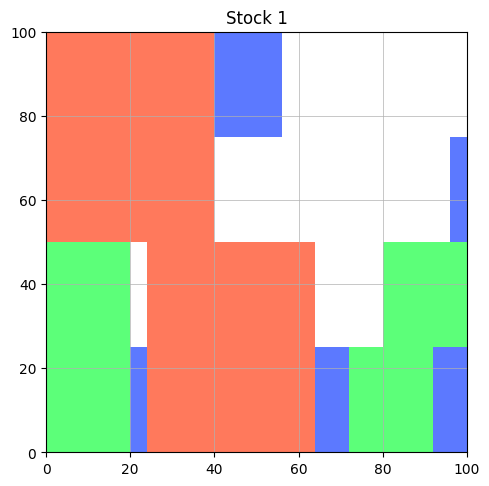

C:\Users\chuon\AppData\Local\Temp\ipykernel_19608\3029157257.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_001_animation.gif...
Animation saved to results\q_learning_order_001_animation.gif

Processing Order: order_002
Canvas Size: [100, 100]
  Table: 40x50 (qty: 1)
  Chair: 20x25 (qty: 6)
  Leg: 4x25 (qty: 20)
Stock Count: 1
Waste Rate: 0.4286
Fitness: 0.7
Runtime(s): 0.4502
Total Reward: 151.0


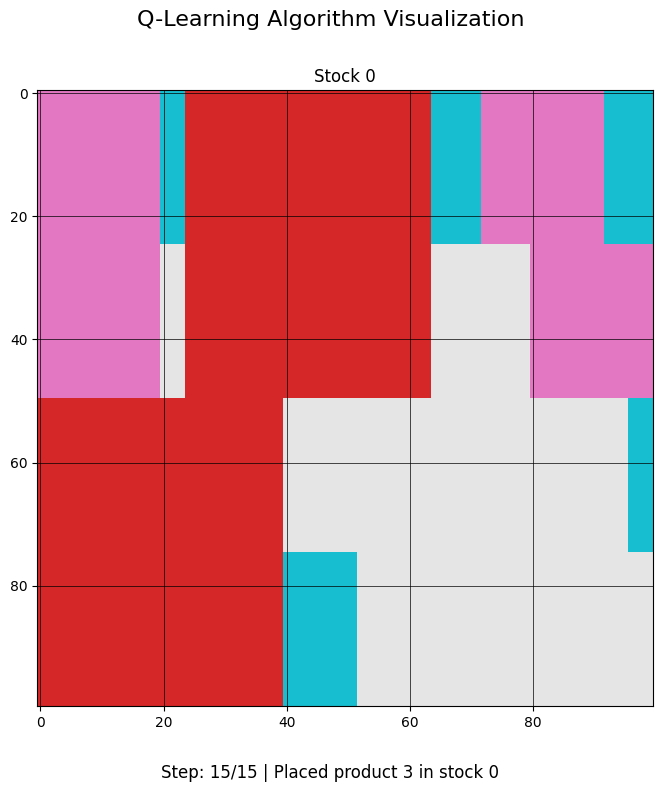

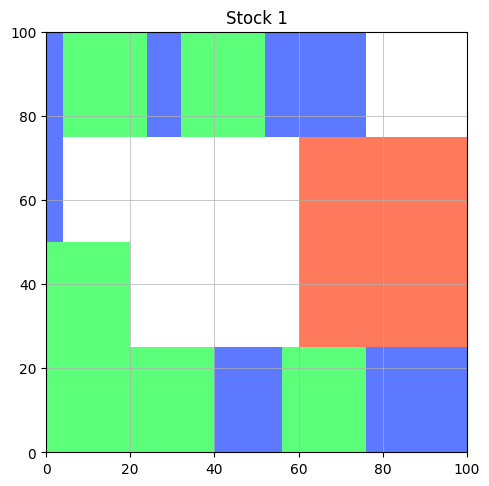

C:\Users\chuon\AppData\Local\Temp\ipykernel_19608\3029157257.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_002_animation.gif...
Animation saved to results\q_learning_order_002_animation.gif

Processing Order: order_003
Canvas Size: [100, 100]
  Table: 40x50 (qty: 3)
  Chair: 20x25 (qty: 6)
  Leg: 4x25 (qty: 25)
Stock Count: 2
Waste Rate: 0.7391
Fitness: 0.575
Runtime(s): 0.3628
Total Reward: 81.0


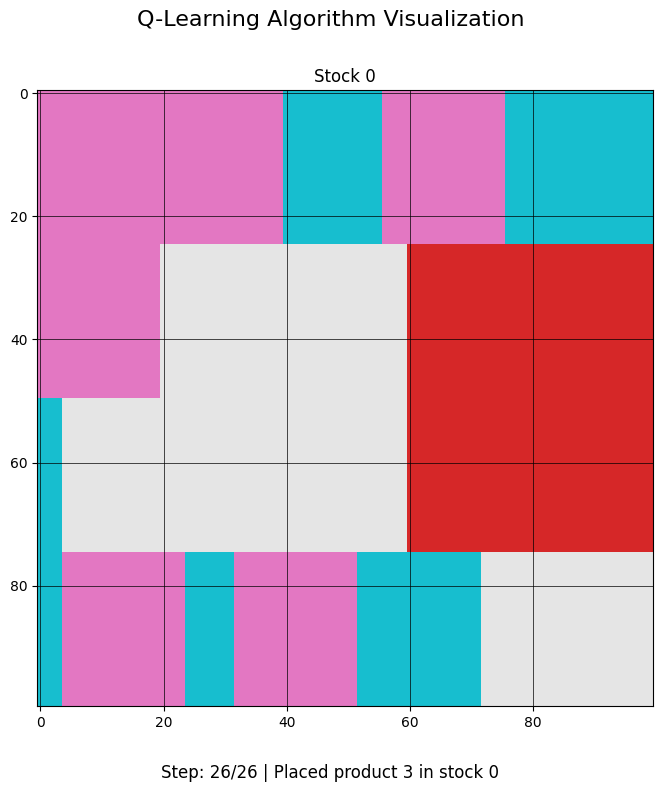

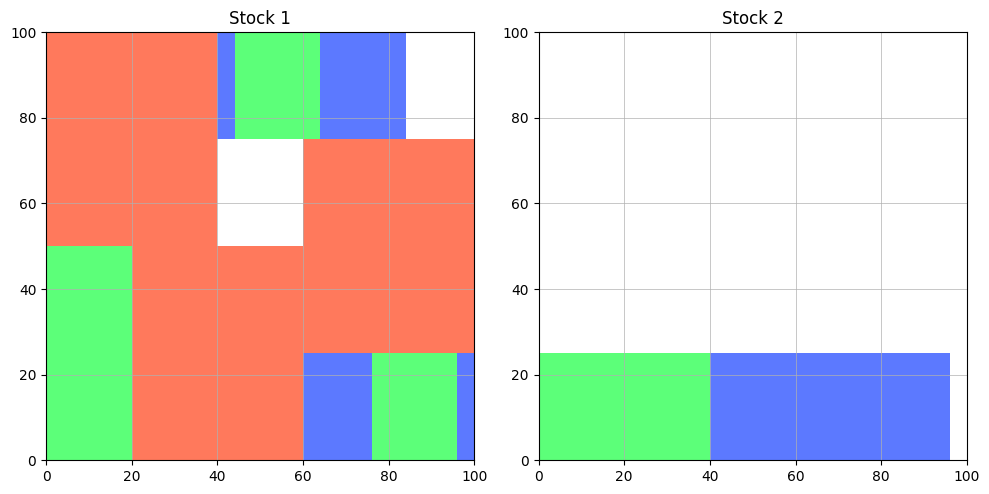

C:\Users\chuon\AppData\Local\Temp\ipykernel_19608\3029157257.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_003_animation.gif...
Animation saved to results\q_learning_order_003_animation.gif

Processing Order: order_004
Canvas Size: [100, 100]
  Table: 40x50 (qty: 4)
  Chair: 20x25 (qty: 8)
  Leg: 4x25 (qty: 30)
Stock Count: 2
Waste Rate: 0.3333
Fitness: 0.75
Runtime(s): 1.2252
Total Reward: 156.0


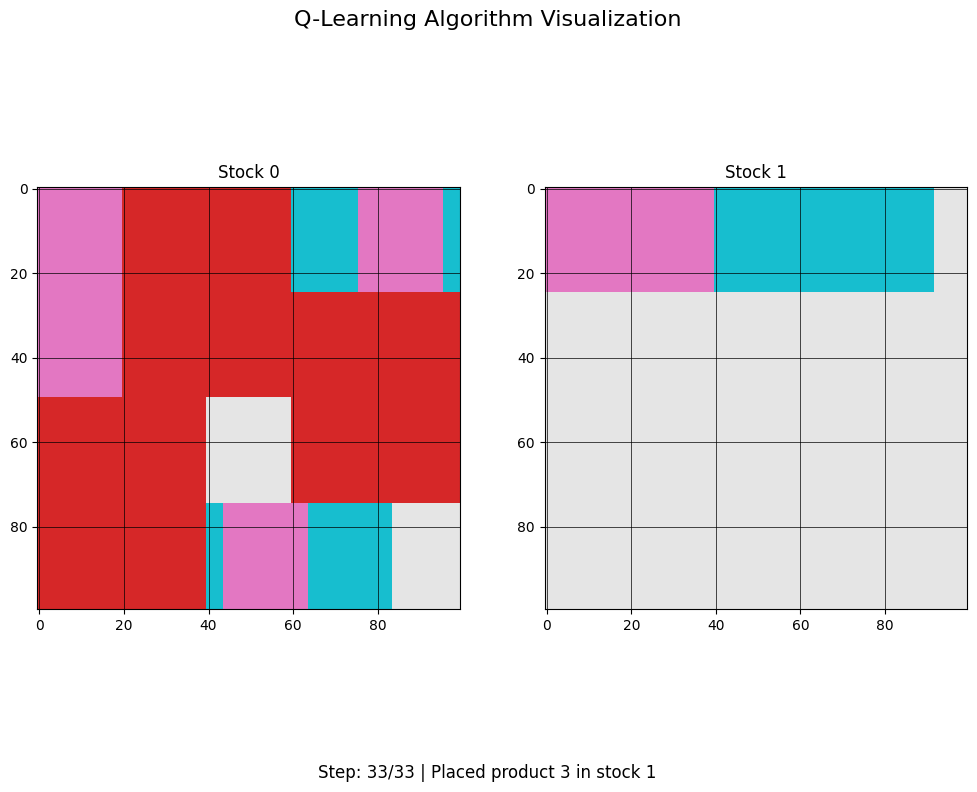

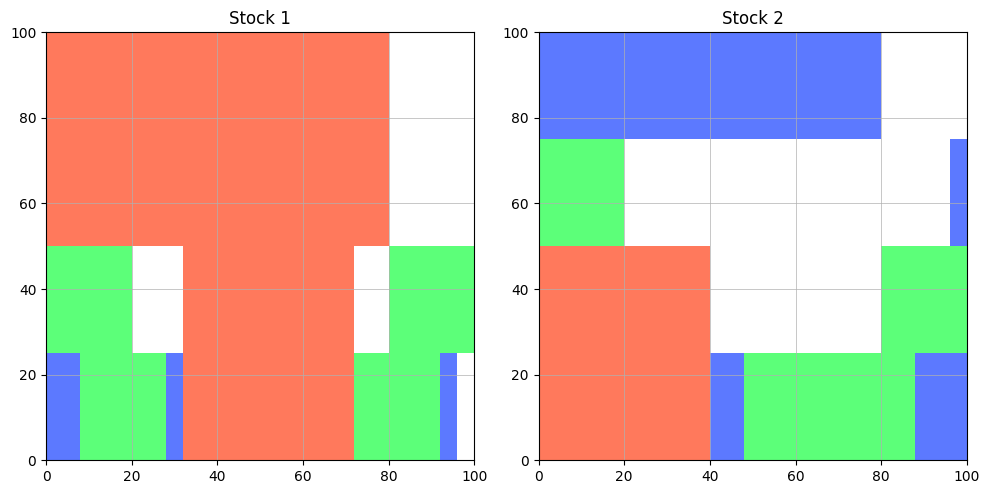

C:\Users\chuon\AppData\Local\Temp\ipykernel_19608\3029157257.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_004_animation.gif...
Animation saved to results\q_learning_order_004_animation.gif

Q-learning BenchMark Results
----------------------------------------------------------------------
Order ID     Stock Count  Waste Rate   Fitness      Runtime(s)   Reward      
order_001    1            0.4286       0.7000       0.2175       96.0000     
order_002    1            0.4286       0.7000       0.4502       151.0000    
order_003    2            0.7391       0.5750       0.3628       81.0000     
order_004    2            0.3333       0.7500       1.2252       156.0000    


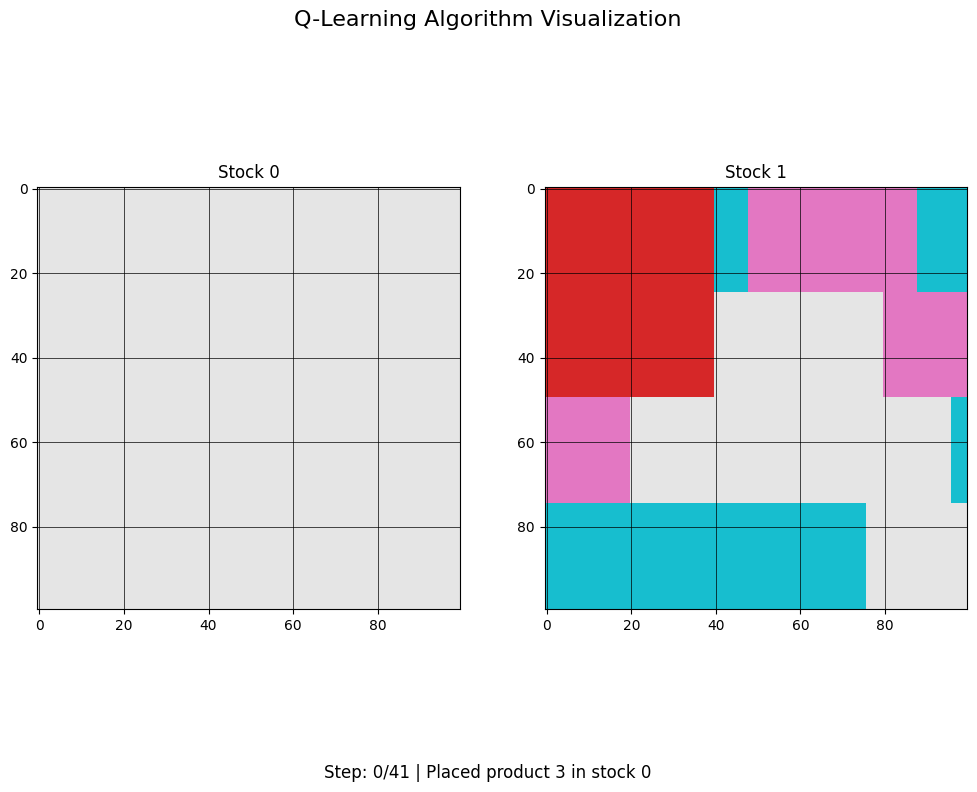

In [17]:
# -------------------------------
# MAIN
# -------------------------------
if __name__ == "__main__":
    # Đọc dữ liệu đơn hàng từ file test.json
    with open("E:/Q_learning (1)/Q_learning/test.json", "r") as f:
        orders = json.load(f)
    
    # Khởi tạo agent Q-learning và load pre-trained Q-table
    agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.0)  # epsilon = 0 để luôn chọn hành động tốt nhất
    q_table_file = "E:/Q_learning (1)/q_table.pkl"
    if os.path.exists(q_table_file):
        with open(q_table_file, "rb") as f:
            agent.q_table = pickle.load(f)
        print("Loaded pre-trained Q-table from", q_table_file)
    else:
        print("File", q_table_file, "not found! Vui lòng đảm bảo file pre-trained Q-table tồn tại.")
        exit(1)
    
    benchmark_results = []
    
    for order in orders:
        canvas_size, products_data = parse_order(order)
        print("\nProcessing Order:", order["order_id"])
        print("Canvas Size:", canvas_size)
        for prod in products_data:
            print(f"  {prod['name']}: {prod['width']}x{prod['length']} (qty: {prod['quantity']})")
        
        env = MultiStockCuttingEnv(canvas_size=canvas_size, products_data=products_data)
        
        start_time = time.time()
        history, total_reward = simulate_episode_history(agent, env, max_steps=50)
        runtime = time.time() - start_time
        
        waste_rate, fitness = calculate_waste_fitness(env)
        stock_count = len(env.stocks)
        
        benchmark_results.append({
            "Order ID": order["order_id"],
            "Stock Count": stock_count,
            "Waste Rate": waste_rate,
            "Fitness": fitness,
            "Runtime(s)": runtime,
            "Total Reward": total_reward
        })
        
        print("Stock Count:", stock_count)
        print("Waste Rate:", round(waste_rate, 4))
        print("Fitness:", round(fitness, 4))
        print("Runtime(s):", round(runtime, 4))
        print("Total Reward:", total_reward)
        
        # Trực quan hóa kết quả cuối cùng
        visualize_best_solution(env)
        # Tạo animation từ lịch sử các bước của Q-learning
        fig, ani = create_animation(history, "Q-Learning")
        save_animation_as_gif(ani, f"q_learning_{order['order_id']}_animation.gif", fps=1)
    
    print("\nQ-learning BenchMark Results")
    print("-" * 70)
    header = "{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format("Order ID", "Stock Count", "Waste Rate", "Fitness", "Runtime(s)", "Reward")
    print(header)
    for r in benchmark_results:
        print("{:<12} {:<12} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
            r["Order ID"],
            r["Stock Count"],
            r["Waste Rate"],
            r["Fitness"],
            r["Runtime(s)"],
            r["Total Reward"]
        ))